## Overview

1. [Single Cell Model](#single-cell-model)
2. [Network Simulations](#network-simulations)
3. [Mean Field Model](#mean-field-model)
4. [Whole Brain Model](#whole-brain-model)
5. [PCI](#pci)
6. [BOLD and FC](#bold-and-fc)
7. [Dynamical Analysis](#dynamical-analysis)

In [3]:
%precision 2
%load_ext autoreload
%autoreload 2

In [4]:
%run setup.py

Everything is now installed. You can proceed. 


<a class="anchor" id="single-cell-model"></a>
### Single Cell Model

In this implementations we select the **AdEx model**, described as following: 


$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

These equations are used in the `eqs` variable of the Brian implementation.

You can select a different model and adjust the `eqs` and the relevant parameters of the model accordingly.

In [5]:
#These are the arguments and default values - to try different parameters refer to the script
%run single_cell_sim.py --help

usage: single_cell_sim.py [-h] [--type TYPE] [--kwargs KWARGS] [--iext IEXT]
                          [--time TIME]

optional arguments:
  -h, --help       show this help message and exit
  --type TYPE      type of cell (RS or FS) (default: RS)
  --kwargs KWARGS  String representation of kwargs - change the first argument
                   to "use": True before adding your kwargs, e.g: "{"use":
                   True, "b": 60}" (default: {"use": False})
  --iext IEXT      input current (nA) (default: 0.3)
  --time TIME      Total Time of simulation (ms) (default: 200)


Simulation of a single neuron. In this case we simulate the activity of a regular spiking cell, with adaptation.

cell parameters --NOT-- in SI units


WARNING    'EL' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -64. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 85. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


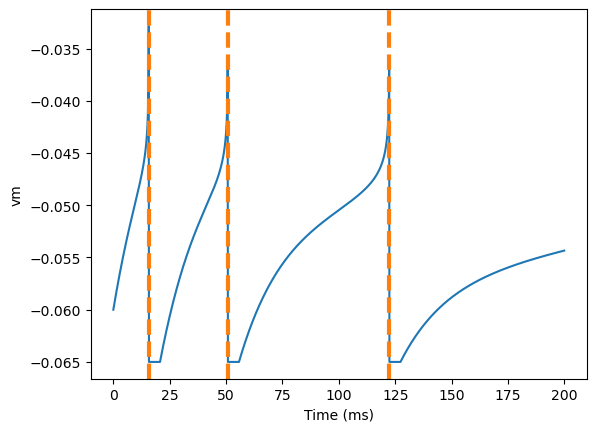

In [6]:
%run single_cell_sim.py --type='RS' --kwargs '{"use": True, "b":85}'

<a id="network-simulations"></a>
### Network Simulations

In [26]:
#These are the arguments and default values - for more changes go to the script
%run adex_simulation_network.py --help

usage: adex_simulation_network.py [-h] [--cells CELLS] [--iext IEXT]
                                  [--input INPUT] [--plat_dur PLAT_DUR]
                                  [--time TIME] [--save_path SAVE_PATH]
                                  [--save_mean SAVE_MEAN]
                                  [--save_all SAVE_ALL] [--kwargs KWARGS]

optional arguments:
  -h, --help            show this help message and exit
  --cells CELLS         cell types of the populations - do not pass single
                        cells (default: FS-RS)
  --iext IEXT           external input (Hz) (default: 0.5)
  --input INPUT         Stable input amplitude (Hz) (default: 0)
  --plat_dur PLAT_DUR   If 0 the input will be applied for the whole duration
                        of the simulation (default: 0)
  --time TIME           Total Time of simulation (ms) (default: 1000)
  --save_path SAVE_PATH
                        save path (default: None)
  --save_mean SAVE_MEAN
                        save me

cell parameters --NOT-- in SI units
b_e=  70
--##Start simulation##--
--##End simulation##--


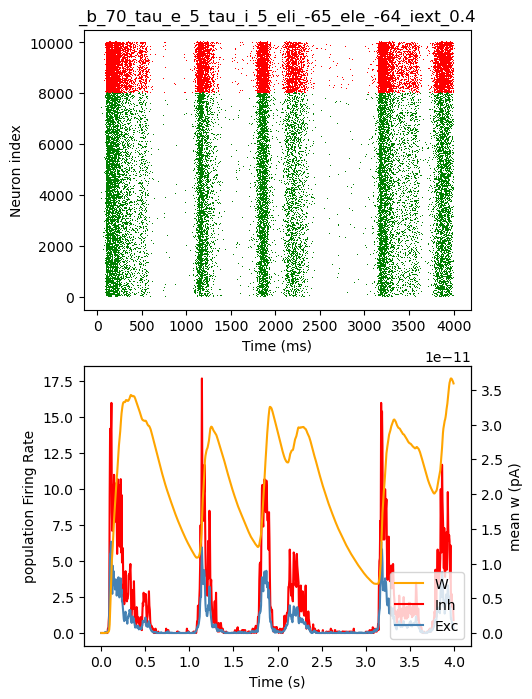

 done


In [18]:
%run adex_simulation_network.py --time 4000 --kwargs '{"use":True, "b_e":70}' --iext 0.4 --cells 'FS-RS_10'

<a id="mean-field-model"></a>
### Mean Field Model

In [11]:
%run MF_script_with_OS.py --help

usage: MF_script_with_OS.py [-h] [--cells CELLS] [--b_e B_E] [--iext IEXT]
                            [--tau_e TAU_E] [--tau_i TAU_I] [--T T]
                            [--use_new USE_NEW] [--time TIME]
                            [--file_fs FILE_FS] [--file_rs FILE_RS]
                            [--input INPUT]

optional arguments:
  -h, --help         show this help message and exit
  --cells CELLS      cell types of the populations (default: FS-RS)
  --b_e B_E          adaptation - in pA (default: 0.0)
  --iext IEXT        external input - in Hz (default: 0.3)
  --tau_e TAU_E      excitatory synaptic decay - in ms (default: 5.0)
  --tau_i TAU_I      inhibitory synaptic decay - in ms (default: 5.0)
  --T T              time constant - in ms (default: 20.0)
  --use_new USE_NEW  use input parameters - if False: will use the ones in
                     params file (default: True)
  --time TIME        Total Time of simulation - in s (default: 10)
  --file_fs FILE_FS  fit for fs (defa

In [22]:
kwargs = "{'use': True, 'b_e':70}"
time = 4
iext=0.4

file_fs = "./Tf_calc/data/FS-cell_CONFIG1_fit.npy"
file_rs = "./Tf_calc/data/RS-cell0_CONFIG1_fit.npy"

command = f"MF_script_with_OS.py --kwargs {kwargs} --time {time} --file_fs {file_fs} --file_rs {file_rs} --iext {iext} "

%run $command

usage: MF_script_with_OS.py [-h] [--cells CELLS] [--iext IEXT] [--input INPUT]
                            [--plat_dur PLAT_DUR] [--T T] [--kwargs KWARGS]
                            [--time TIME] [--file_fs FILE_FS]
                            [--file_rs FILE_RS]
MF_script_with_OS.py: error: unrecognized arguments: True, b_e:70}


SystemExit: 2

starting
done


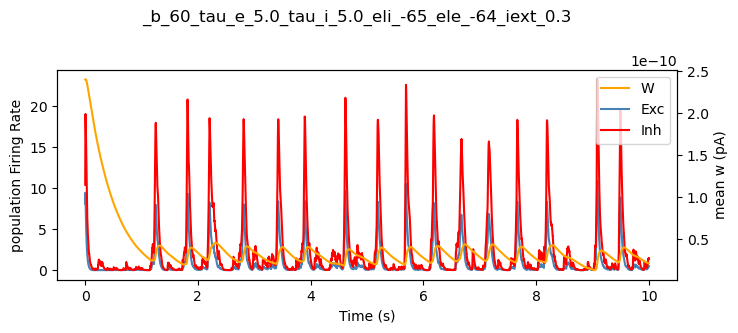

In [14]:
%run MF_script_with_OS.py --b_e=60

<a id="whole-brain-model"></a>
### Whole Brain Model

#### Choose a connectome 

You have various options:

1. Get a default connectivity from TVB software

    - `parameters.parameter_connection_between_region['default'] = True`

2. Point to a zip folder (required files included in the zip folder: centres, tract_lengths, weights)

    - `parameters.parameter_connection_between_region['from_file'] = True`
    - `parameters.parameter_connection_between_region['path'] = path/to/zip/file`
    - `parameters.parameter_connection_between_region['conn_name'] = 'Connectivity.zip'` (add the actual zip name)

3. Point to an h5 file

    - `parameters.parameter_connection_between_region['path'] = path/to/h5/file CHECK`

4. Point to an unzipped folder that contains necessarily tract_lengths.txt and weights.txt (optional: region_labels, centres, cortical)

    - `parameters.parameter_connection_between_region['path'] = path/to/folder/containing/files`


In [10]:
path_conn

'/DATA/Maria/paper_pipeline/tvb_model_reference/data/connectivity'

In [50]:
# Choose the connectome

cwd = os.getcwd()
path_conn = os.path.join(cwd, "TVB/tvb_model_reference/data/connectivity")
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_conn
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

##### Set up the parameters of the simulation

In [12]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [0]
tau_es = [5]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

In [52]:
parameters.parameter_simulation['path_result'] = './TVB/result/synch/'

In [51]:
simulator = sim_init(parameters)
Nnodes = simulator.number_of_nodes

2024-05-27 19:01:39,939 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


Overwriting...


#### Run the simulation


Here is an example of changing `tau_e` and `b_e`.

You can instead change `tau_i`, or other values (look at docs of `adjust_parameters`), by setting `tau_i = desired_value` as an argument in the functions:
- `adjust_parameters`
- `get_result`

and set `change_of = 'tau_i'` in:
- `access_results`
- `plot_tvb_results`



In [55]:
# Choose values of b_e and tau_e
bvals = [0, 100]
tau_es = [5, 5]
iext=0.315e-3
run_sim = 2000
cut_transient = 200

In [112]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,
                       cut_transient=cut_transient, run_sim=run_sim, Iext = iext)
    

Simulation Completed successfully


#### Load the Results

In [56]:
# Params to load 
bvals = [5, 60]
tau_es = [3.75, 5]

bvals = [5, 60]
tau_es = [3.75, 5]
iext=0.315e-3
#Which variables to load:
vars_int = ['E', 'I' ,'noise']

#Load
result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, vars_int = vars_int,Iext = iext)
    result.append(result_param)


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1
Loading:  _b_e_60_tau_e_5_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1


In [64]:
# For explanation of the indexes of the result, uncomment the following:

access_results(for_explan, bvals, tau_es, change_of='tau_e')


Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 5 and tau_e= 3.75
result[1]: for b_e = 60 and tau_e= 5

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
Raw monitor : result[i][0]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for Raw monitor:
For E : result[i][0][0]
For I : result[i][0][1]
For noise : result[i][0][2]

These arrays have shape: time_points x number_of_nodes: (18001, 76)


#### Plot the Results

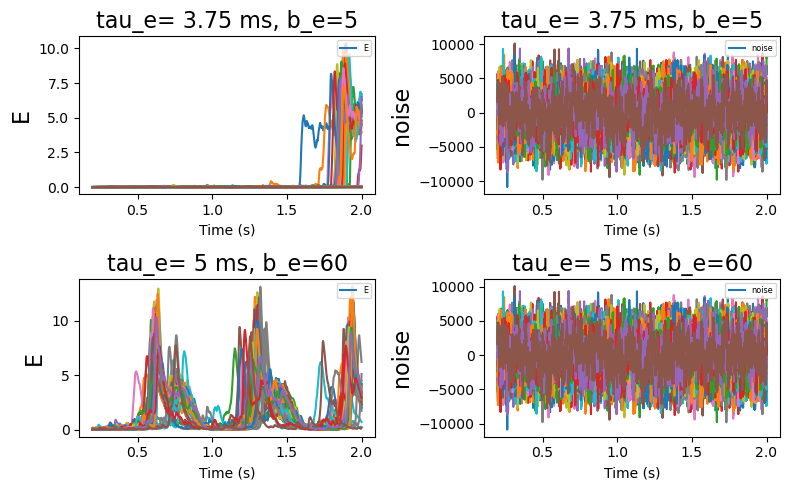

In [57]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Raw'

#which variables
var_select = ['E',  'noise']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75], [60,5]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, Iext=iext)

<a id="pci"></a>
### Evoked Dynamics and PCI

#### Set up the parameters of the simulation

In [ ]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

These are additional parameters to adjust for the stimulation

In [ ]:
## Set the parameters of the stimulus 
stimval = 1e-3 #  stimulus strength in kHz - HERE NO ZERO ANYMORE
t_analysis  = 300. #in ms, for PCI analysis

# Loop over seeds to obtain multi5ple realizations of the model
Nseeds = 2 

# Onset time of the stimulus
stimtime_allseeds = np.random.rand(Nseeds)*(run_sim - cut_transient - 2*t_analysis) + t_analysis + cut_transient # shuffle in ms the start time of stimulus 
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start (it will be shufled)
stim_region = 5

#### Run Simulation

In [ ]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

In [ ]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    for seed in range(Nseeds):
        run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                       cut_transient=cut_transient, run_sim=run_sim)


#### Calculate PCI

In [ ]:
#Calculate PCI
params = [[5, 3.75, 2], [60, 5, 2]] 

for b_e, tau_e, n_seeds in params:
    calculate_PCI(parameters, n_seeds, run_sim, cut_transient, stimval=stimval, b_e=b_e, tau_e=tau_e, n_trials = 1)

#### Plot PCI #

Loading paper params:
For wake : b_e=5, tau=5.0
For nmda : b_e=30, tau=3.75
For gaba : b_e=30, tau=7.0
For sleep : b_e=120, tau=5.0
Seeds = 60, n_trials=5, stimvals=[1e-05, 0.0001, 0.001]
Creating PCI_all
Creating dataframe


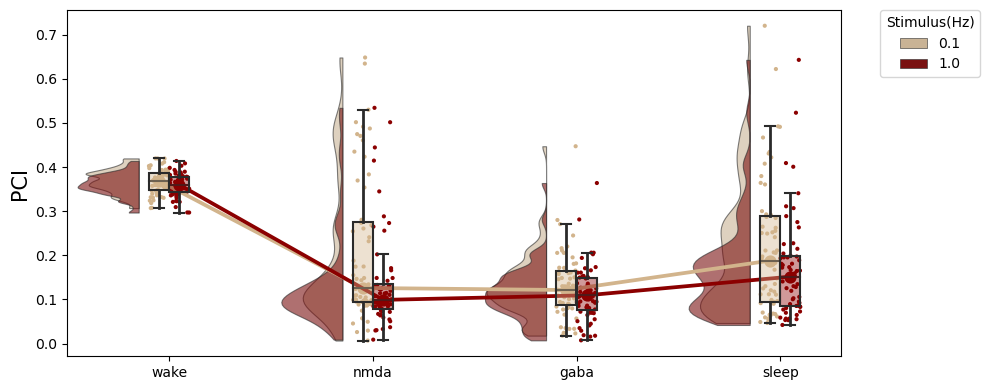

In [58]:
params = [[5, 3.75, 2], [60, 5, 2]] # b_e, tau, nseeds
conditions = ['nmda', 'sleep'] #conditions that the params describe - used for the x tick labels
stimvals = [1e-3] #stimvals to load
n_trials=1 #how many trials were used for the PCI

pick_stim = [1, 0.1] # stimulus strength to plot

#set this to True if you want to plot the already run stims, it will load params automatically
local_folder= True 


plot_raincloud_with_stats(parameters, params, n_trials=n_trials, stimvals=stimvals, pick_stim=pick_stim, conditions= conditions, local_folder=local_folder)

<a class="anchor" id="bold-and-fc"></a>
### Simulating BOLD signal and calculating FC-SC Correlation

#### Set up the parameters of the simulation

In [ ]:
# Do that to initialize the parameters
parameters.__init__()

In [5]:
# Choose the connectome

cwd = os.getcwd()
path_conn = os.path.join(cwd, "TVB/tvb_model_reference/data/connectivity")
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_conn
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

For the BOLD monitor long simulations are needed, so set a long `run_sim`

In [6]:
## Set the parameters of the simulation:
run_sim = 100000 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

Set `parameter_monitor['Bold'] = True` 
- (if you want you can simulate another monitor)

In [7]:
#Set Bold Monitor
parameters.parameter_monitor['Bold'] = True
# parameters.parameter_monitor['parameter_Bold']['period'] = 2000 

#Deactivate Raw, and keep Temporal Average instead ( faster )
parameters.parameter_monitor['Raw'] = False
parameters.parameter_monitor['TemporalAverage'] = True
parameters.parameter_monitor['parameter_TemporalAverage']['variables_of_interest'] = [0,1]

In [60]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

#Set a subfolder where the results will be saved, otherwise they can be overwritten 
additional_path_folder='Bold/'

#### Run Simulation

In [ ]:
# Run sim


for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                cut_transient=cut_transient, run_sim=run_sim,additional_path_folder=additional_path_folder)


#### Load Results

In [62]:
# Params to load 
bvals = [5]
tau_es = [3.75]

#Which Variables to load
vars_int = ['E' ]

result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, 
    vars_int = vars_int, additional_path_folder=additional_path_folder)
    result.append(result_param)


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 2


In [1]:
# For explanation of the indexes of the result, uncomment the following:
access_results(for_explan, bvals, tau_es, change_of='tau_e')


NameError: name 'access_results' is not defined

#### Plot Results


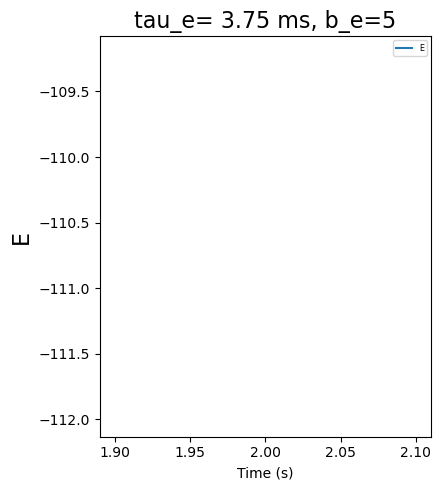

In [63]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Bold'

#which variables to plot
var_select = ['E']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, 
                 additional_path_folder=additional_path_folder, desired_time=10)

#### Compute Corr FC and SC

450 76


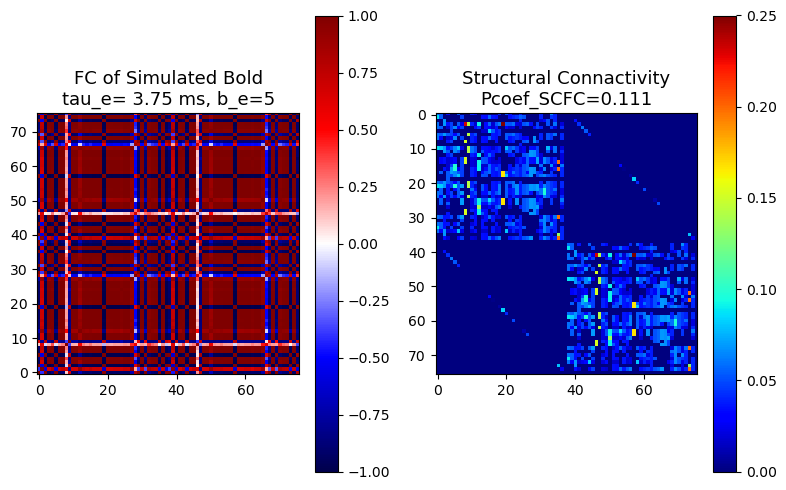

In [97]:
#Add the SC
SC=simulator.connectivity.weights

plot_FC_SC(parameters,params, result, for_explan, cut_transient, run_sim, SC, 
            additional_path_folder=additional_path_folder,desired_time=10)

<a class="anchor" id="dynamical-analysis"></a>
### Dynamical Analysis 

#### Network Simulations and Survival Time

1. First run network simulations for different values of tau_e/tau_i and b_e
2. Calculate the survival time for each combination of tau/b_e

In [59]:
%run net_sims_dyn_analysis.py --help

usage: net_sims_dyn_analysis.py [-h] [--b_e_range B_E_RANGE]
                                [--tau_e_range TAU_E_RANGE]
                                [--tau_i_range TAU_I_RANGE] [--nseeds NSEEDS]
                                [--time TIME] [--save_path SAVE_PATH]
                                [--overwrite OVERWRITE]
                                [--surv_time_calc SURV_TIME_CALC]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: 0,30,1)
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default:
                        5.,7.,10)
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (default:
                        3.,9.,0.1)
  --nseeds NSEEDS  

In [61]:
%run net_sims_dyn_analysis.py --b_e_range '0,22,2' --tau_i_range '5, 5.5, 0.2' --nseeds '0,4,2' --surv_time_calc True --save_path './trials/'

Done! Network simulations are saved in ./trials//network_sims/ 
survival time (tau_i_mean_array.npy) 
with the respective values of b_e (tau_i_heatmap_bvals.npy) and 
tau_i (tau_i_heatmap_taus.npy) in ./trials/


You can separately calculate the survival times if you have already run the network simulations:
- adjust the parameters accordingly

In [55]:
bvals = np.arange(0,22,step=2)
tauIv = np.arange(5.,5.5,step=0.2)
tauEv= np.arange(5.,9.,step=10)
Nseeds = np.arange(0,4,2)

if len(tauEv)==1 and len(tauIv)>1:
    tau_i_iter = True
    tau_values = tauIv
elif len(tauEv)>1 and len(tauIv)==1:
    tau_i_iter = False
    tau_values = tauEv

calculate_survival_time(bvals, tau_values, tau_i_iter, Nseeds, save_path ='./trials/')


Done! Saved in : ./trials/


#### Mean Field and b_critical Calculation


In [73]:
%run calculate_b_crit.py --help

usage: calculate_b_crit.py [-h] [--b_e_range B_E_RANGE]
                           [--tau_e_range TAU_E_RANGE]
                           [--tau_i_range TAU_I_RANGE] [--save_path SAVE_PATH]
                           [--overwrite OVERWRITE]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: [ 0 1 2 3 4 5 6 7 8 9 10
                        11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
                        29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
                        47 48 49 50 51 52 53 54 55 56 57 58 59])
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default: [5.])
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (def

In [21]:
%run calculate_b_crit.py --tau_i_range '5,7,0.2' --overwrite=True --save_path='./trials/' 

5.0 5.0
crit b =  20
5.2 5.0
crit b =  18
5.4 5.0
crit b =  16
5.6000000000000005 5.0
crit b =  13
5.800000000000001 5.0
crit b =  11
6.000000000000001 5.0
crit b =  9
6.200000000000001 5.0
crit b =  7
6.400000000000001 5.0
crit b =  5
6.600000000000001 5.0
crit b =  3
6.800000000000002 5.0
crit b =  2


#### Plot the heatmap

In [48]:
#This is an example with few values of tau_i and b_e
load= 'tau_i'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, save_path='./trials/')
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, save_im=False, z_max=200, precalc=False, line_color='yellow')

Or you can load directly a pre-calculated array with the mean survival time (averaged over seeds) for each combination of tau/b_e : 

In [45]:
load= 'tau_e'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, precalc=True)
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, precalc=True, save_im=False, z_max=200, line_color='black', colorscale="jet") 